In [1]:
# to generate result sheet autoly
import pandas as pd 
import numpy as np 
import scipy
# import xlrd 
import sklearn

from Gibbs_model_probit import Gibbs_sampling
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from utils import baseline_lr,baseline_esnet,baseline_justmean
from utils import baseline_LogitElsnet,baseline_justmode,baseline_random,baseline_LogitLR,baseline_RanForest,baseline_Gibbs_zhe,baseline_SVM
from utils import baseline_LogitElsnet_leaveone,baseline_LogitLR_leaveone,baseline_SVM_leaveone
from utils import logis_regression_5,kernel_svm_regression_5,random_forest_regression_5,gpr_regression_5,logis_lasso_regression_5
from sklearn.model_selection import KFold
from scipy.stats import binom 
from scipy.stats import norm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange
from Gibbd_zhe import GibbsSampling3
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut
import time
from sklearn.preprocessing import StandardScaler
# from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern
from sklearn.linear_model import LogisticRegression

In [2]:
# data_loading 
np.random.seed(123)

# data_table = pd.read_csv('../data/processed/all_feature_p1_lip_total_single.csv')
# data_table_cont = pd.read_csv('../data/processed/all_feature_p2_spicie_cont_single.csv')
data_table_binary = pd.read_csv('../data/processed/all_feature_p2_spicie_binary_single.csv')




In [3]:
# last seven columns are labels
# all_feature_cont = data_table_cont.iloc[:,1:-3]
all_feature_binary = data_table_binary.iloc[:,1:-3]
# all_feature_binary

In [4]:
# P1(mHSPC) testtosterone suppression failure: CER(ceramide), DG(diacylglycerol), TG(triaclyglycerol)
# P2(mCRPC) overall survival:  CER(ceramide), Sph(Sphingosine), Acylcarnitine(acylcarnitine)
def feature_filter(df):
    all_feature = list(df)
    feature_dict = {}
    feature_dict['gene'] = [item for item in all_feature if 'gene_' in item]
    # feature_dict['TG'] = [item for item in all_feature if 'lip_P1' in item and 'lip_P1_TG' not in item] # remove the TG lip
    # lip_feature_P2 = [item for item in all_feature if 'lip_P2' in item and '_Cer' not in item]
    # lip_feature_all =  [item for item in all_feature if 'lip_' in item and 'P1_Cer' not in item]
    
    feature_dict['TG'] = [item for item in all_feature if 'lip_P1_TG' in item]

    feature_dict['Cer'] = [item for item in all_feature if '_Cer' in item]
    feature_dict['DG'] = [item for item in all_feature if 'lip_P1_DG' in item]

    feature_dict['Acy'] = [item for item in all_feature if '_Acylcarnitine' in item]
    feature_dict['Sph'] = [item for item in all_feature if '_Sph' in item]
    feature_dict['sig'] = [item for item in all_feature if 'signature' in item]

    return feature_dict

In [5]:
# gene_feature,lip_feature_P1,lip_feature_P2,lip_feature_all,\
#     lip_feature_TG,lip_feature_Cer,lip_feature_DG,\
#         lip_feature_Acylcarnitine,lip_feature_Sph,lip_feature_sig = feature_filter(data_table_binary)

# data_table = data_table_cont
data_table = data_table_binary
# data_table = data_table_binary_standard


feature_dict = feature_filter(data_table)
one_feature_P1 = [['TG'],['Cer'],['DG']]
one_feature_P2 = [['Cer'],['Acy'],['Sph']]

two_feature_P1 = [['TG','Cer'],['TG','DG'],['DG','Cer']]
two_feature_P2 = [['Acy','Cer'],['Sph','Cer'],['Sph','Acy']]

three_feature_P1 = [['TG','Cer','DG']]
three_feature_P2 = [['Cer','Acy','Sph']]


In [6]:
index = ['logistic reg','logistic reg-lasso','linear-kernel svm','RBF-kernel svm','RBF-kernel GPR','matern-kernel GPR' ]
result_table = pd.DataFrame(index = index)



# target ='1= death; 0=alive'
target ='gap_surv_time_class'
# sub_target = '_early_death'
sub_target = '_long_survive'

# target = 'ADT_if_fail'

Y = data_table[target].values

if target == 'gap_surv_time_class':
    # for this target, Y=0 means early death, Y=1 means long survival, Y=2 for the middle value
    if sub_target == '_early_death':
        Y = (Y==0)*1 # early death predict
        target = target + sub_target
    elif sub_target == '_long_survive':
        Y = (Y==1)*1 # long survive predict
        target = target + sub_target


In [7]:
# weight analysis 

def logis_regression_weight_analysis(X,Y,l1_ratio=0.5):
    
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)

    clf_list = []

    best_index = 0
    best_score = 0
    loss = []
    
    for i,index in enumerate (kf.split(X)):
        train_index, test_index = index
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

#         clf = LogisticRegression(random_state=0,penalty='elasticnet',solver='saga',l1_ratio=l1_ratio
# ).fit(X_train, y_train)

        clf = LogisticRegression(random_state=0,penalty='l1',solver='saga',l1_ratio=l1_ratio
).fit(X_train, y_train)

        clf_list.append(clf)

        test_score = clf.score(X_test,y_test)
        # print(test_score)
        loss.append(test_score)

        if test_score>best_score:
            best_index = i
            best_score = test_score
    

    return np.array(loss).mean(),clf_list[best_index]


def get_sparse_name(clf,feature_name,top=30):
    weight = clf.coef_.squeeze()
    
    weight_table = pd.DataFrame()
    weight_table['feature_name'] = feature_name
    weight_table['feature_weight'] = clf.coef_.squeeze()
    weight_table_de  = weight_table.sort_values('feature_weight',ignore_index=False).iloc[0:top]
    weight_table_in  = weight_table.sort_values('feature_weight',ascending=False,ignore_index=False).iloc[0:top]

    return weight_table_de,weight_table_in

# fes = ['DG','Cer','gene'] # optimal feature groups for survial prediction 

# fes = ['DG','gene']# optimal feature groups for ADT-fail prediction
# fes = ['Sph','gene']# optimal feature groups for early-dead prediction
# fes = ['Sph','Cer','gene']# optimal feature groups for early-death prediction
fes = ['Acy','Cer','Sph','gene']# optimal feature groups for long-survive prediction


feature_name = [name for item in fes for name in feature_dict[item]]

feature_list = [data_table[feature_dict[item]].values for item in fes]

X = np.concatenate(feature_list,1)

# log_lasso_loss = logis_lasso_regression_5(X,Y,0.1)

# weight_table_de,weight_table_in = get_sparse_name(clf,feature_name,top=30)


In [8]:
clf = LogisticRegression(random_state=0,penalty='elasticnet',solver='saga',l1_ratio=0.1
    ).fit(X, Y)


weight = clf.coef_.squeeze()

weight_table = pd.DataFrame()
weight_table['feature_name'] = feature_name
weight_table['feature_weight'] = clf.coef_.squeeze().round(3)
weight_table['feature_weight_abs'] = np.abs(clf.coef_.squeeze())

# sort the weight table by the abs value of the weight
weight_table_sort  = weight_table.sort_values('feature_weight_abs',ascending=False,ignore_index=True)

# weight_table_sort.head(30)

/home/jupiter/anaconda3/envs/ifar/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:

top_ratio = 0.5
top_N = int(len(weight_table_sort)*top_ratio)

folder_path = '../patent_result/Exceptional_Survival/'

import os

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

top_feature_name = weight_table_sort.iloc[0:top_N]['feature_name'].values

# extact the top features values from the data table, and the Patient_ID

top_feature_values = data_table[['Patient_ID']+list(top_feature_name)]


# save the top_feature_values files

top_feature_values.to_csv(folder_path+'patient_feature_values.csv',index=False)
# save another version of excel file
top_feature_values.to_excel(folder_path+'patient_feature_values.xlsx',index=False)

# save the top-N rows of weight_table_sort, delete the abs weight column

weight_table_sort.iloc[0:top_N].drop('feature_weight_abs',axis=1).to_csv(folder_path+'feature_weight_top-%.1f.csv'%(top_ratio),index=False)

# save another version of excel file
weight_table_sort.iloc[0:top_N].drop('feature_weight_abs',axis=1).to_excel(folder_path+'feature_weight_top-%.1f.xlsx'%(top_ratio),index=False)


In [10]:
# make a txt file, for each line, specifically showing the computation of the score using the top features and the weight for each patient


def computation_process(i,top_feature_values,weight_table_sort):
    # compute the score for the i-th patient
    # also specify the feature-wise computation, like feature1*weight1+feature2*weight2+...

    weight = weight_table_sort['feature_weight'].iloc[0:top_N].values

    feature_values = top_feature_values.iloc[i,1:].values

    score =  sigmoid(np.dot(weight,feature_values))

    label = "> 0.5  =>   predict patient will be exceptional survival" if score>0.5 else "< 0.5  => predict patient will not be exceptional survival"

    Patient_ID = top_feature_values.iloc[i,0]

    string_weight = ' + '.join(['%.3f*%d'%(weight[i],feature_values[i]) for i in range(top_N)])

    final_string = 'Patient_ID: %s, computation: 1/(1+exp(- (%s))) =%.3f  %s '%(Patient_ID, string_weight, score, label)

    return final_string

def sigmoid(x):
    return 1/(1+np.exp(-x))

N_pathent = X.shape[0]


# overwrite the file
with open(folder_path+'score_computation.txt','w+') as f:
# with open(folder_path+'score_computation.txt','w+') as f:

    for i in range(N_pathent):
        f.write(computation_process(i,top_feature_values,weight_table_sort)+'\n\n')
    
    f.close()




In [17]:
def cut_the_top(clf,ratio_cut = 0.5):
    # ratio_cut = 1-ratio_cut
    if ratio_cut>0:
        N = len(clf.coef_.squeeze())
        N_cut = int(ratio_cut*N)
        sort_abs = np.sort(np.abs(clf.coef_.squeeze()))
        THR = sort_abs[-N_cut]
        clf.coef_ = np.where(np.abs(clf.coef_)>= THR,clf.coef_,0  )

    else:
        pass
    return clf


sparse_ratio = 0.3
cut_ratio_list = [0.1,0.3,0.5,0.7,0.9,1]
# cut_ratio_list = [1,0.9,0.7,0.5,0.3,0.1]


kf = KFold(n_splits=5)
kf.get_n_splits(X)

clf_list = []

best_index = 0
best_score = 0
loss_cut = []

for cut_ratio in cut_ratio_list:
    loss = []
    for i,index in enumerate (kf.split(X)):
        train_index, test_index = index
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        clf = LogisticRegression(random_state=0,penalty='elasticnet',solver='saga',l1_ratio=sparse_ratio
    ).fit(X_train, y_train)

    #     clf = LogisticRegression(random_state=0,penalty='l1',solver='saga',l1_ratio=sparsr_ratio
    # ).fit(X_train, y_train)

        # clf_list.append(clf)
        clf = cut_the_top(clf,cut_ratio)

        test_score = clf.score(X_test,y_test)
        # print(test_score)
        loss.append(test_score)
    
    loss_cut.append(np.array(loss).mean())


loss_cut = np.array(loss_cut)
loss_cut




f:\anaconda\conda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
f:\anaconda\conda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
f:\anaconda\conda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
f:\anaconda\conda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
f:\anaconda\conda\envs\pt\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_

array([0.69408867, 0.63842365, 0.59039409, 0.61157635, 0.61157635,
       0.61157635])

num_feature_list

In [18]:
# new_loss_cut = loss_cut-0.07
# new_loss_cut[0] = 0.51
new_loss_cut = np.array([0.5534, 0.6266, 0.68539, 0.69, 0.715, 0.721])

N = len(clf.coef_.squeeze())
num_feature_list = [int(N*(1-cut_ratio)) for cut_ratio in cut_ratio_list[:-1]]
num_feature_list.insert(0,N)
x_list = 1-np.flip(np.array(cut_ratio_list),0)
new_loss_cut


array([0.5534 , 0.6266 , 0.68539, 0.69   , 0.715  , 0.721  ])

In [19]:
# for quick remake figs
import numpy as np
loss_cut  =np.array([0.67315271, 0.61083744, 0.60394089, 0.58349754, 0.57660099,
       0.57660099])
cut_ratio_list = [0.1,0.3,0.5,0.7,0.9,1]
new_loss_cut = np.array([0.5534, 0.6266, 0.68539, 0.69, 0.715, 0.721])

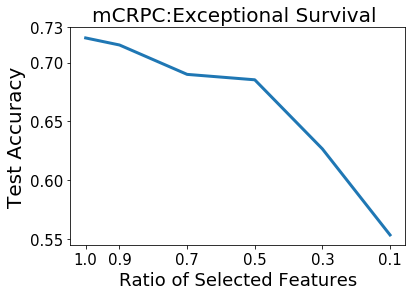

In [21]:
import matplotlib.pyplot as plt

x_list = 1-np.flip(np.array(cut_ratio_list),0)

plt.plot(x_list,np.flip(new_loss_cut,0),linewidth=3)
plt.ylabel('Test Accuracy',fontsize=20)
# plt.xlabel('Number of Selected Features',fontsize=18)
plt.xlabel('Ratio of Selected Features',fontsize=18)
plt.yticks(np.array([0.55, 0.60, 0.65, 0.70, 0.73]),fontsize=15)
# plt.xticks(np.array(cut_ratio_list),num_feature_list,fontsize=15)
plt.xticks(x_list,np.flip(np.array(cut_ratio_list),0),fontsize=15)

plt.title('mCRPC:Exceptional Survival ',fontsize=20)
plt.savefig('mCRPC_Exceptional Survival.pdf',bbox_inches='tight')
plt.show()